# Pre-Whitening for Robust Detection of Lagged Dependencies in Time Series Data

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import ccf

import plotly.figure_factory as ff
from plotly.figure_factory import create_distplot

## Helpers

In [14]:
def simulate_ar1(n, phi, sigma=1.0, rng=None):
    rng = np.random.default_rng(rng)
    e = rng.normal(scale=sigma, size=n)
    x = np.zeros(n)
    for t in range(1, n):
        x[t] = phi * x[t-1] + e[t]
    return x

def xcorr_at_lags(x, y, lags):
    """
    corr(X_t, Y_{t-k}) for each k in lags (k can be negative).
    k > 0 means X leads Y by k (X_t compared with Y_{t-k}).
    """
    x = np.asarray(x)
    y = np.asarray(y)
    out = []
    n = len(x)
    for k in lags:
        if k >= 0:
            # compare x[k:] with y[:n-k] so indices align: x_t with y_{t-k}
            xs = x[k:]
            ys = y[:(n-k)]
        else:
            # kk = -k
            xs = x[:(n-(-k))]
            ys = y[-k:]
        out.append(np.corrcoef(xs, ys)[0, 1])
    return np.array(out)

def plot_density(data, labels, title):
    """
    Plot empirical density function for some series

    """
    if not isinstance(data, list):
        data = [data]
    if not isinstance(labels, list):
        labels = [labels]
    fig = create_distplot(
        hist_data=data,
        group_labels=labels,
        show_hist=False,
        show_rug=False,
    )

    # Adding the title and centering it
    fig.update_layout(
        title_text=title,
        title_x=0.5
    )

    fig.show()
    return

def prewhiten_driver_and_filter_other(x, y, ar_order=5):
    """
    Fit AR(ar_order) to x. Let u_t be residuals (whitened driver).
    Apply the same AR filter to y to get v_t.
    Return u, v.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Fit AR(p) via ARIMA(p,0,0)
    ar_model = ARIMA(x, order=(ar_order, 0, 0), trend="c").fit()

    # Whitened driver = residuals (innovations-ish): xhat(t) - x(t)
    u = ar_model.resid

    # Apply same AR filter to y:
    phi = ar_model.arparams  # length p
    c = ar_model.params[0]  # intercept

    p = ar_order
    v = np.zeros_like(y)
    v[:] = np.nan
    for t in range(p, len(y)):
        v[t] = y[t] - c - np.dot(phi, y[t-p:t][::-1])

    # Trim initial NaNs in v and corresponding u to match lengths
    u2 = u[p:]
    v2 = v[p:]
    return u2, v2, ar_model

def plot_ccf_style(lags, vals, title):
    plt.axhline(0, linewidth=1)
    plt.stem(lags, vals)
    plt.title(title)
    plt.xlabel("lag k in corr(X_t, Y_{t-k})")
    plt.ylabel("sample correlation")

## Demo 1: No true relationship, but strong autocorrelation

$x = \phi_x x_{t-1} + \varepsilon_{x, t}$
$y = \phi_y y_{t-1} + \varepsilon_{y, t}$

Where $\phi_x = 0.9$, $\phi_y = 0.9$, and $\varepsilon_{x, t}, \varepsilon_{y, t} \sim \mathcal{N}(0, 1)$

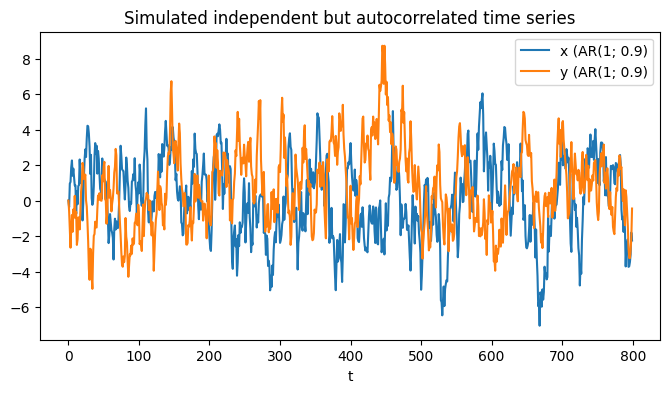

In [15]:
rng = 123
n = 800
phi_x = 0.9
phi_y = 0.9

x = simulate_ar1(n, phi_x, rng=rng)
y = simulate_ar1(n, phi_y, rng=rng + 1)  # independent of x, but also persistent

plt.figure(figsize=(8, 4))
plt.plot(x, label="x (AR(1; 0.9)")
plt.plot(y, label="y (AR(1; 0.9)")
plt.legend()
plt.title("Simulated independent but autocorrelated time series")
plt.xlabel("t")
plt.ylabel(None)
plt.show()


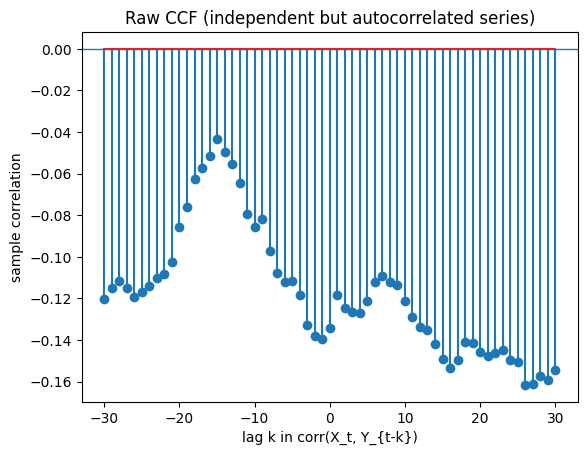

In [16]:
lags = np.arange(-30, 31)
raw_cc = xcorr_at_lags(x, y, lags)

plot_ccf_style(lags, raw_cc, "Raw CCF (independent but autocorrelated series)")

In [17]:
u, v, fit = prewhiten_driver_and_filter_other(x, y, ar_order=5)
pw_cc = xcorr_at_lags(u, v, lags)

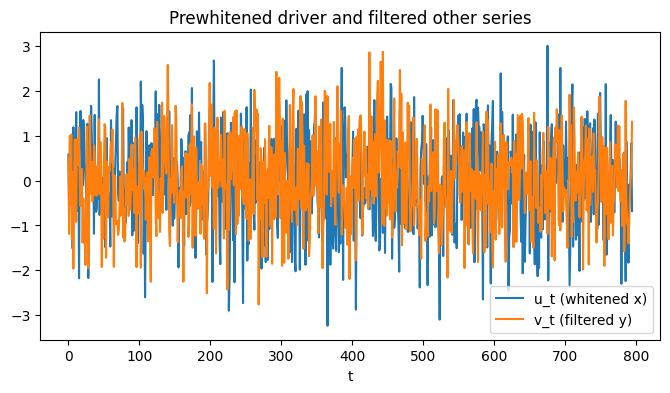

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(u, label="u_t (whitened x)")
plt.plot(v, label="v_t (filtered y)")
plt.legend()
plt.title("Prewhitened driver and filtered other series")
plt.xlabel("t")
plt.ylabel(None)
plt.show()

In [21]:
plot_density(data=[u,v], labels=['u', 'v'], title="Density of prewhitened series u (x) and filtered v (y)")

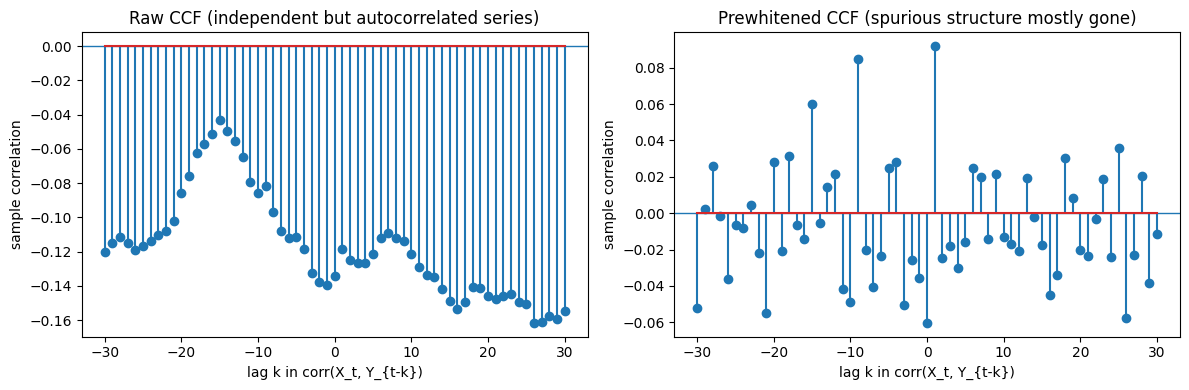

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plot_ccf_style(lags, raw_cc, "Raw CCF (independent but autocorrelated series)")
plt.subplot(1, 2, 2)
plot_ccf_style(lags, pw_cc, "Prewhitened CCF (spurious structure mostly gone)")
plt.tight_layout()
plt.show()


## Demo 2: True lagged effect (Y responds to past X)

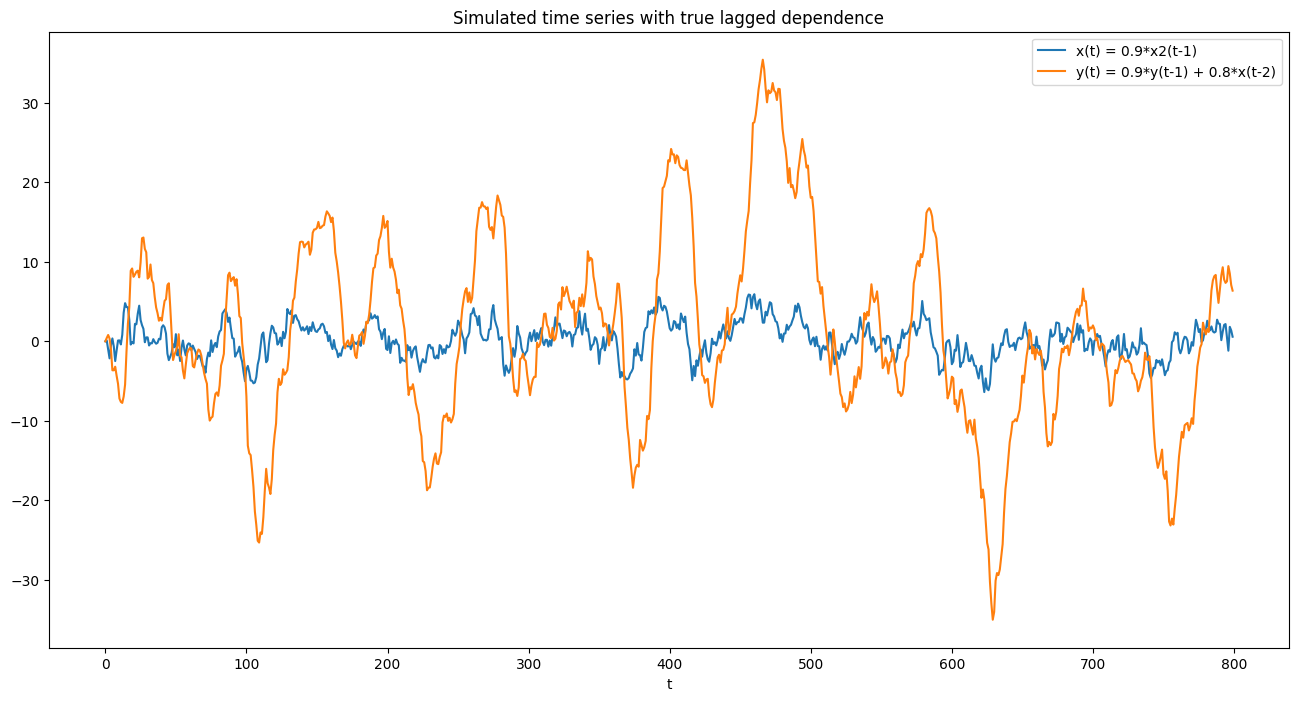

In [31]:
# Construct Y with both its own AR(1) persistence and a real dependence on X_{t-2}
true_lag = 2
beta = 0.8

x2 = simulate_ar1(n, phi_x, rng=rng + 10)
e2 = np.random.default_rng(rng + 11).normal(size=n)

y2 = np.zeros(n)
for t in range(1, n):
    y2[t] = phi_y * y2[t-1] + e2[t] + beta * x2[t - true_lag]

plt.figure(figsize=(16, 8))
plt.plot(x2, label=f"x(t) = {phi_x}*x2(t-1)")
plt.plot(y2, label=f"y(t) = {phi_y}*y(t-1) + {beta}*x(t-{true_lag})")
plt.legend()
plt.title("Simulated time series with true lagged dependence")
plt.xlabel("t")
plt.show()

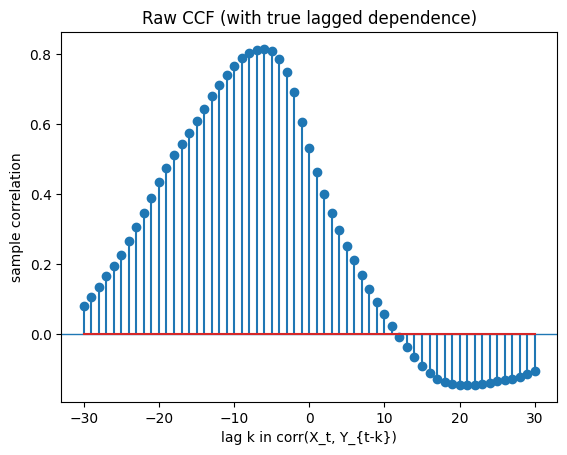

In [25]:
raw_cc2 = xcorr_at_lags(x2, y2, lags)
plot_ccf_style(lags, raw_cc2, "Raw CCF (with true lagged dependence)")

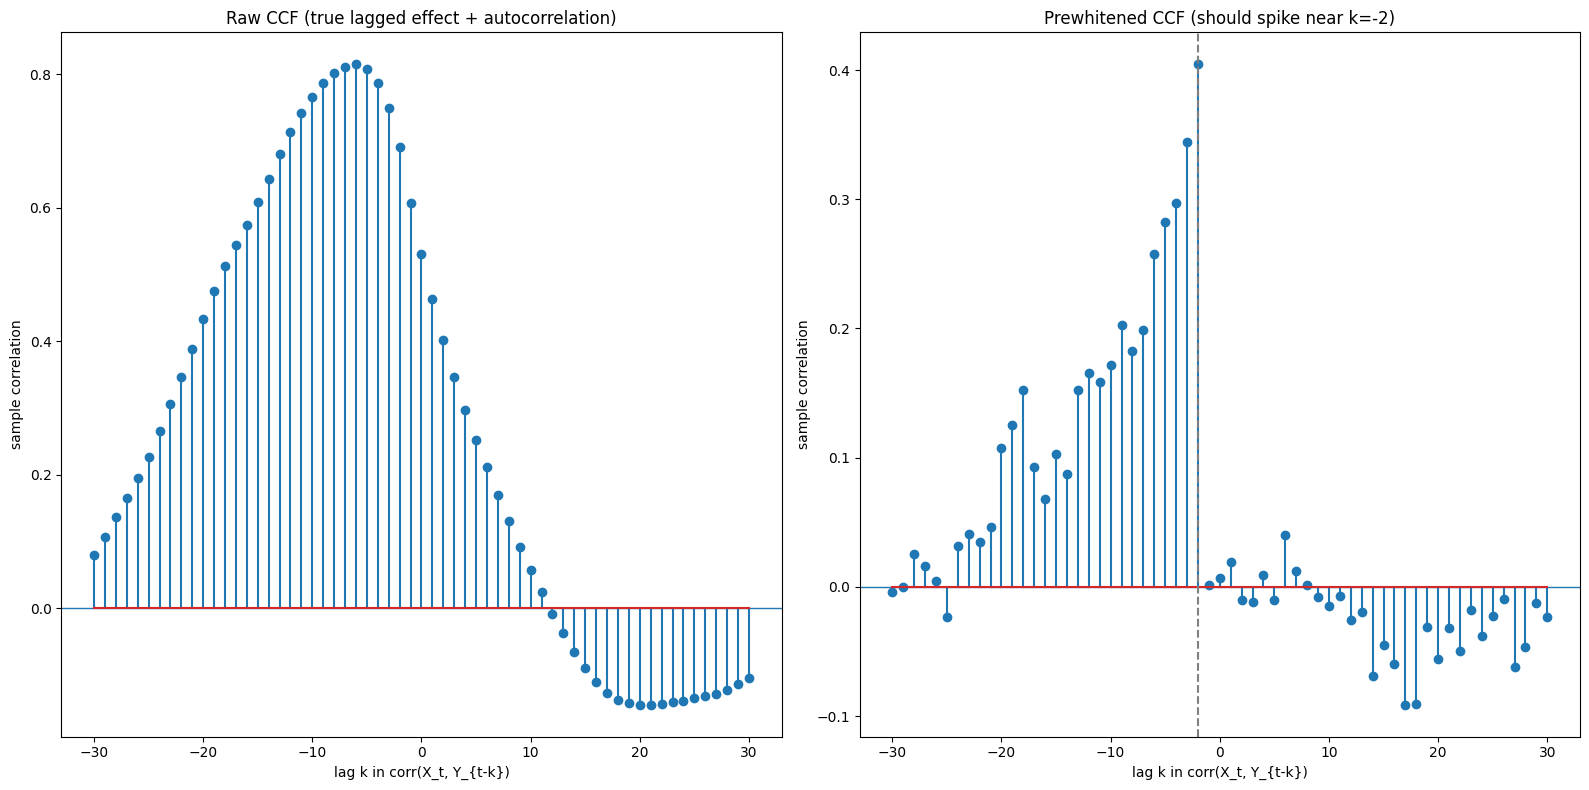

AR fit summary for driver (demo 1):
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  800
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -1144.808
Date:                Mon, 29 Dec 2025   AIC                           2303.616
Time:                        19:44:01   BIC                           2336.408
Sample:                             0   HQIC                          2316.213
                                - 800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0725      0.335      0.217      0.828      -0.583       0.728
ar.L1          0.9129      0.036     25.687      0.000       0.843       0.983
ar.L2         -0

In [39]:
u2, v2, fit2 = prewhiten_driver_and_filter_other(x2, y2, ar_order=5)
pw_cc2 = xcorr_at_lags(u2, v2, lags)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_ccf_style(lags, raw_cc2, "Raw CCF (true lagged effect + autocorrelation)")
plt.subplot(1, 2, 2)
plot_ccf_style(lags, pw_cc2, f"Prewhitened CCF (should spike near k=-{true_lag})")
plt.axvline(-true_lag, color='grey', linestyle='--', label='True lag')
plt.tight_layout()
plt.show()

print("AR fit summary for driver (demo 1):")
print(fit.summary())

print("\nAR fit summary for driver (demo 2):")
print(fit2.summary())
